# The Validation partition of the dataset

This notebook presents some of the common practices in training a classification model, namely:

- use of a validation set
- early stopping
- learning rate scheduler

# Auxiliary Function

In [1]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


# The Dataset

The dataset in this notebook is a subset of GTSRB, a dataset of traffic signs. A subset is used to make it more practical to use in class, nevertheless, everything mentiond in here also applies to the full dataset.

The full dataset can be found in [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html).

The dataset has 43 classes covering a variety of common traffic signs. Our subset will be only the speed limit signs. This comprises 8 classes.

Samples from each class:

![class 0](images/class0.png) ![class 1](images/class1.png) ![class 2](images/class2.png) ![class 3](images/class3.png) ![class 4](images/class4.png) ![class 5](images/class5.png) ![class 6](images/class6.png) ![class 7](images/class7.png)

The images are stored in a set of 8 folders, one for each class. The folder name will be used to identify the class. The folder structures is as follows:

![folder structure](images/train_folder.png)

Both training and test sets follow the same convention

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

# Dataset loading

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

PATH_TRAINING_SET = 'H:/vcpi/gtsrb/train_full'
PATH_TEST_SET = 'H:/vcpi/gtsrb/test'

BATCH_SIZE = 32

EPOCHS = 20

cuda:0


As can be seen from the samples above, the size varies from image to image. The model takes a fixed size image, hence, we nedd to resize the images as they are loaded to a common size. In here we are going to consider 32x32.

In [4]:
transform = transforms.Compose(
    [transforms.Resize((32,32)), transforms.ToTensor()]) 

In [5]:
train_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)

# No shuffle is required for the test set, also the batch size can be completely different
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

## Some info on the dataset, and sample batch

In [6]:
images, targets = next(iter(train_loader))
print("Batch shape: ", images.shape)

print(targets)

Batch shape:  torch.Size([32, 3, 32, 32])
tensor([1, 5, 7, 5, 2, 1, 5, 6, 5, 2, 1, 4, 1, 3, 2, 5, 2, 3, 6, 5, 6, 4, 7, 7,
        5, 1, 3, 1, 3, 2, 1, 4])


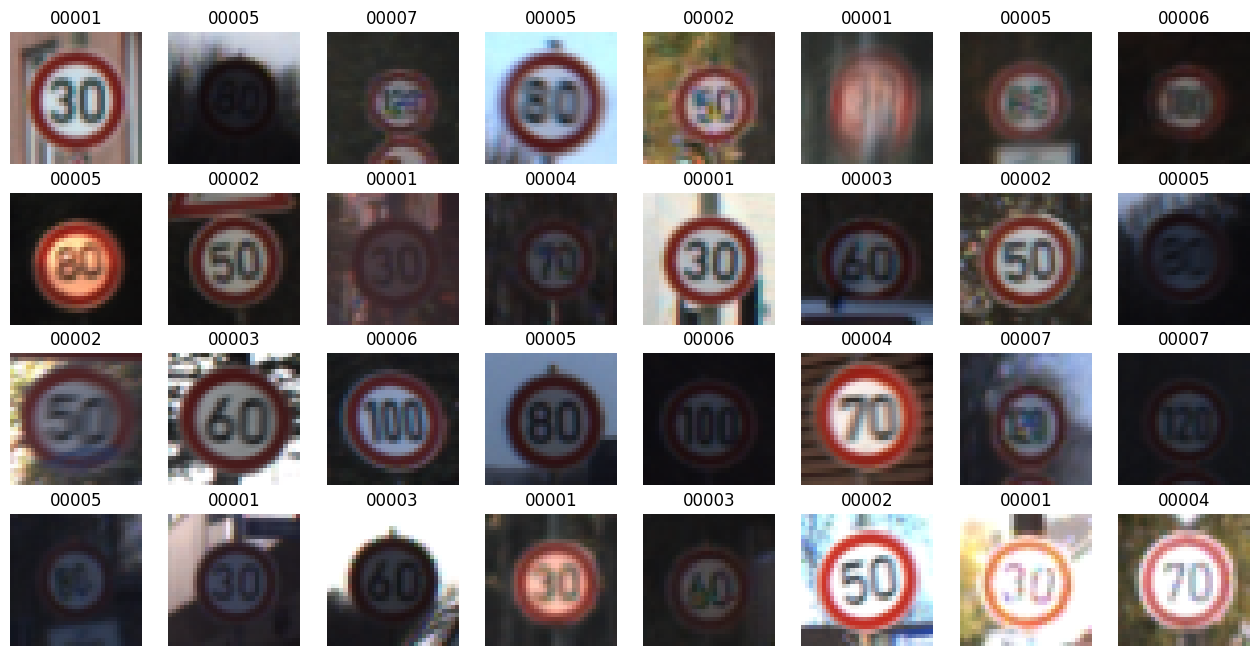

<Figure size 640x480 with 0 Axes>

In [7]:

vcpi_util.show_images(4,8, images, targets, train_set.classes) 

# The model

In [8]:
class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 26, 26)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 24, 24)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)
        
        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 5 * 5 = 1200)
        x = self.fc1(x)        # -> (bs, 10)

        return(x)


model_Conv_I = Conv(len(train_set.classes))
model_Conv_I.to(device)
print(model_Conv_I)

torchinfo.summary(model_Conv_I, input_size=(BATCH_SIZE, 3, 32, 32))

Conv(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=8, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [32, 16, 30, 30]          32
├─ReLU: 1-3                              [32, 16, 30, 30]          --
├─Conv2d: 1-4                            [32, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 28, 28]          64
├─ReLU: 1-6                              [32, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [32, 32, 14, 14]          --
├─Conv2d: 1-8                            [32, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [32, 48, 12, 12]          96
├─ReLU: 1-10                             [32, 48, 12, 12]          --
├─Conv2d: 1-11                           [32, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [32, 48, 10, 10]          96
├─R

# Train

In [9]:
def train(model, train_loader, test_loader, epochs, loss_fn, optimizer):

    history = {}
    history['accuracy'] = []
    history['test_acc'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)
            
            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        t_correct = 0
        with torch.no_grad():
            for i,t in test_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)

                t_correct += (p == t).sum()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        t_accuracy = 100 * t_correct / len(test_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.4f}; Accuracy: {accuracy:0.4f}; Test_Acc: {t_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['test_acc'].append(t_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
        
    print('Finished Training')

    return(history)


In [10]:
optimizer_I = torch.optim.Adam(model_Conv_I.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

history_I = train(model_Conv_I, train_loader, test_loader, EPOCHS, loss_fn, optimizer_I)

Epoch: 000; Loss: 0.0114; Accuracy: 88.7480; Test_Acc: 96.8345; Elapsed time: 11.8259
Epoch: 001; Loss: 0.0011; Accuracy: 99.2880; Test_Acc: 96.3789; Elapsed time: 8.3944
Epoch: 002; Loss: 0.0005; Accuracy: 99.7261; Test_Acc: 97.6019; Elapsed time: 8.3657
Epoch: 003; Loss: 0.0004; Accuracy: 99.7261; Test_Acc: 98.2014; Elapsed time: 8.2939
Epoch: 004; Loss: 0.0001; Accuracy: 99.9218; Test_Acc: 98.4412; Elapsed time: 8.2424
Epoch: 005; Loss: 0.0006; Accuracy: 99.5618; Test_Acc: 94.6523; Elapsed time: 8.2632
Epoch: 006; Loss: 0.0005; Accuracy: 99.4757; Test_Acc: 98.0336; Elapsed time: 8.3031
Epoch: 007; Loss: 0.0001; Accuracy: 99.9061; Test_Acc: 98.4173; Elapsed time: 8.2753
Epoch: 008; Loss: 0.0003; Accuracy: 99.7496; Test_Acc: 96.9305; Elapsed time: 8.4430
Epoch: 009; Loss: 0.0005; Accuracy: 99.4914; Test_Acc: 98.8249; Elapsed time: 8.4636
Epoch: 010; Loss: 0.0000; Accuracy: 100.0000; Test_Acc: 98.8489; Elapsed time: 8.2714
Epoch: 011; Loss: 0.0000; Accuracy: 100.0000; Test_Acc: 98.7530

In [11]:
torch.save({
        'model':model_Conv_I.state_dict(),
        'optimizer': optimizer_I.state_dict()
        },
        f'model_gtsrb.pt')

Question: Why is the test accuracy higher than the training accuracy in the initial epochs?

# Evaluation

Although it may coincide, the best epoch considering training data accuracy is not always the best epoch for test data accuracy

In [12]:
best_train = np.asarray(history_I['accuracy']).argmax()
best_test = np.asarray(history_I['test_acc']).argmax()

print('Best epoch for train accuracy: :', best_train,' Best epoch for test accuracy: :',  best_test)
print('Test accuracy at epoch ',best_train, ' :', history_I['test_acc'][best_train], 'Test accuracy at epoch ',best_test, ' :', history_I['test_acc'][best_test])


Best epoch for train accuracy: : 10  Best epoch for test accuracy: : 10
Test accuracy at epoch  10  : 98.84892 Test accuracy at epoch  10  : 98.84892


Worst is the fact that training accuracy is not a good predictor for test set accuracy. 

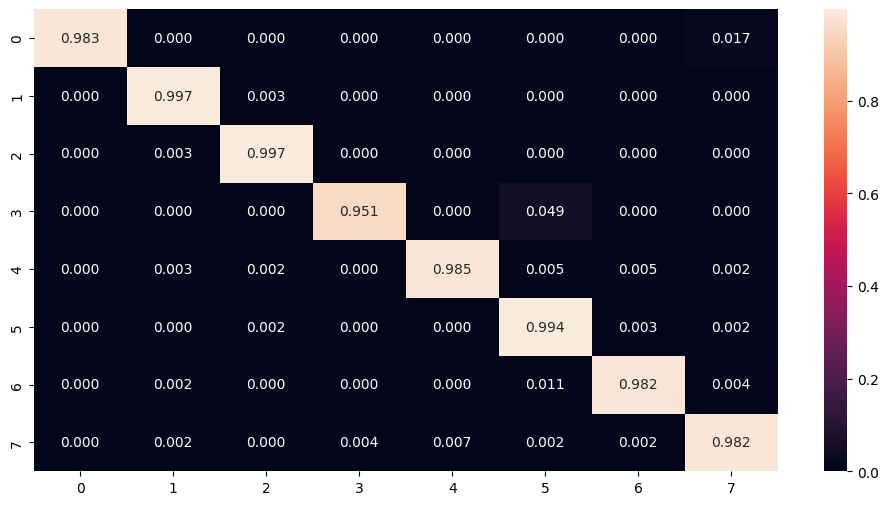

In [13]:
preds = []
ground_truth = []

for images, targets in test_loader:

    logits = model_Conv_I(images.to(device))
    preds_sparse = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_sparse)
    ground_truth.extend(targets.numpy())

vcpi_util.show_confusion_matrix(ground_truth, preds, len(train_set.class_to_idx))

From the confusion matrix, built from the predictions on the test set, we can see that regarding accuracy, not all classes behave the same way.

The histogram presented below shows that class 0 is severely under represented, so that might justify its bad performance. 

- Is there seems a relation between representativeness and accuracy?

- Or is the training set less representative for some classes?

Both are amongst the possible justifications for this behaviour.

## Dataset histogram

This dataset is heavily unbalanced, we'll deal with this in later classes

Counter({2: 2250, 1: 2220, 4: 1980, 5: 1860, 6: 1440, 3: 1410, 7: 1410, 0: 210})


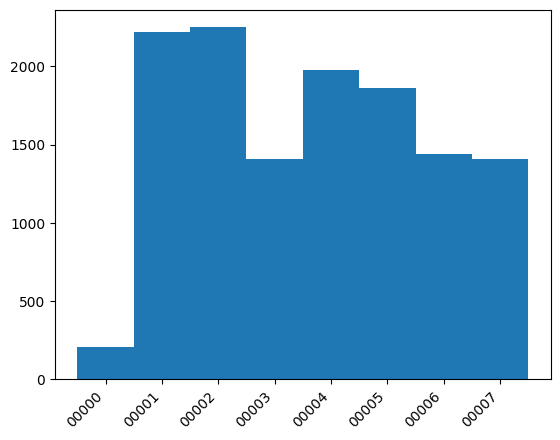

In [14]:
target_list = []
for images, targets in train_loader:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_set.classes)

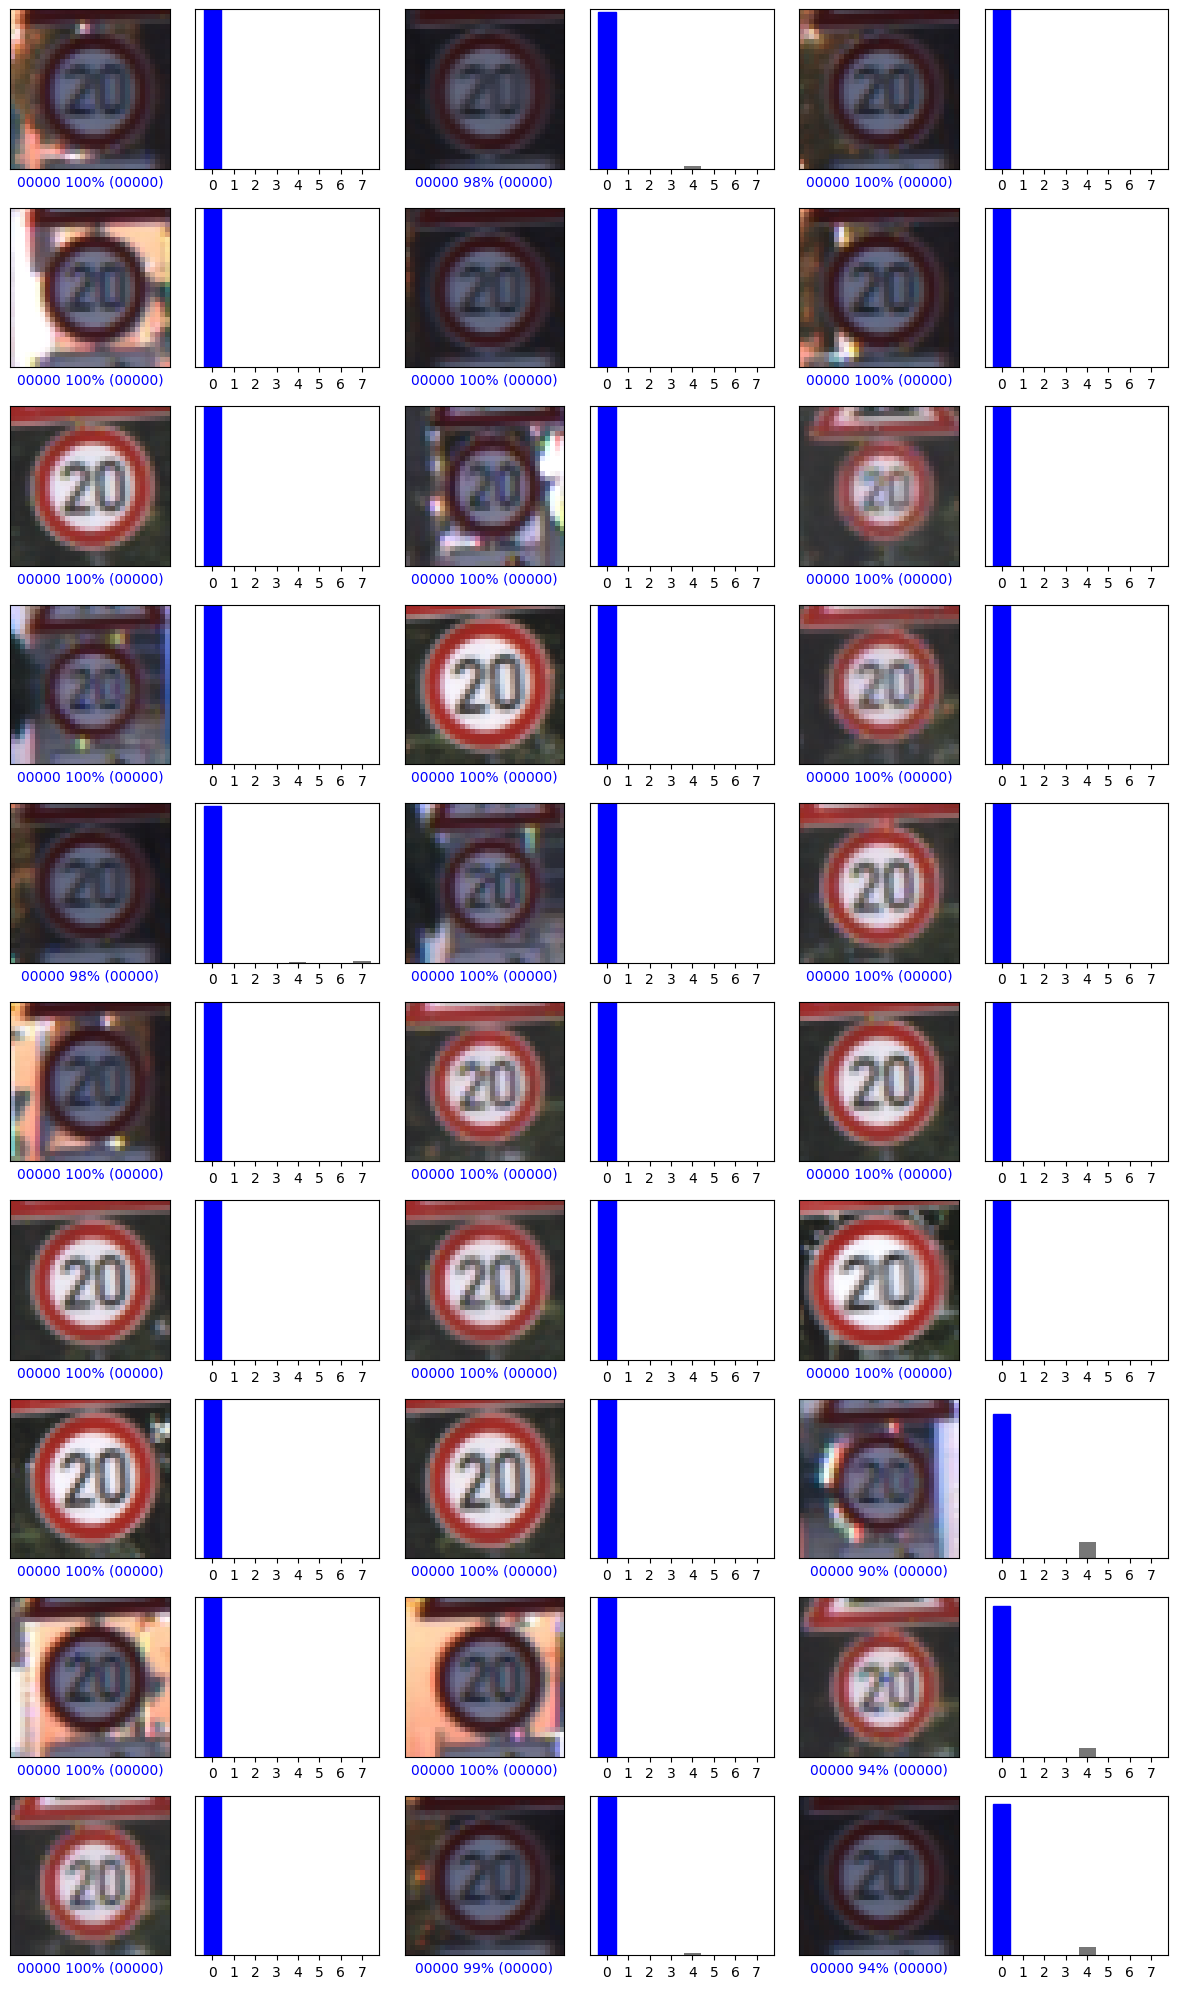

In [15]:
images, targets = next(iter(test_loader))
logits = model_Conv_I(images.to(device))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_set.classes, 10, 3)

# The Validation Set

Why do we need a third dataset?

- Fine tunning a model to provide a good answer on the test set directly is creating a model biased towards that dataset.

- We have no data left to evaluate how our model performs on unseen data

The validation dataset aims at avoiding the training to be solely focused on the training set. This is achieved by having metrics on validation set influence the training process.

This can be achieved without using any of the images of the validation set to compute gradients. Instead, the validation set can be used to determine which model to save, or to adapt hyper parameters such as the learning rate. This is done trough monitoring certain metrics on the validation set, such as the loss.

A good validation set will provide an idea on how the model will perform when faced with unseen data. the test dataset can then be used to corroborate this expectation.

## Building the Validation Dataset

One way to build a validation set is to take a percentage of samples from the train set, i.e. to split the train into two subsets: one for training, and one for validation.

Note that the validation dataset is a compromise, since we are splitting the training data into two subsets: the train and validation datasets. This approach leaves us with less data on the training set.



In [16]:
train_sub, val_sub = torch.utils.data.random_split(train_set, [10200, 2580])

train_sub_loader = torch.utils.data.DataLoader(train_sub, batch_size = BATCH_SIZE, shuffle=True)
val_sub_loader = torch.utils.data.DataLoader(val_sub, batch_size = BATCH_SIZE)

A small cosmetic change to the train function, replacing 'test' with 'val' where appropriate.

In [24]:
def train_II(model, train_loader, val_loader, epochs, loss_fn, optimizer):

    

    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)
            
            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        with torch.no_grad():
            v_correct = 0
            for i,t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)

                v_correct += (p == t).sum()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.4f}; Accuracy: {accuracy:0.4f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(v_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
        
    print('Finished Training')

    return(history)

## Training and evaluating

In [25]:
model_Conv_II = Conv(len(train_set.classes))
model_Conv_II.to(device)

optimizer_II = torch.optim.Adam(model_Conv_II.parameters())


In [26]:
history_II = train_II(model_Conv_II, train_sub_loader, val_sub_loader, EPOCHS, loss_fn, optimizer_II)

Epoch: 000; Loss: 0.0149; Accuracy: 84.5196; Val Acc: 98.0233; Elapsed time: 6.3881
Epoch: 001; Loss: 0.0014; Accuracy: 98.9804; Val Acc: 98.8760; Elapsed time: 6.3929
Epoch: 002; Loss: 0.0006; Accuracy: 99.6078; Val Acc: 99.4186; Elapsed time: 6.3169
Epoch: 003; Loss: 0.0002; Accuracy: 99.9412; Val Acc: 99.6899; Elapsed time: 6.2939
Epoch: 004; Loss: 0.0002; Accuracy: 99.8431; Val Acc: 96.9767; Elapsed time: 6.3597
Epoch: 005; Loss: 0.0009; Accuracy: 99.1569; Val Acc: 98.6822; Elapsed time: 6.3426
Epoch: 006; Loss: 0.0001; Accuracy: 99.9314; Val Acc: 99.7674; Elapsed time: 6.3776
Epoch: 007; Loss: 0.0001; Accuracy: 99.9510; Val Acc: 99.8062; Elapsed time: 6.2879
Epoch: 008; Loss: 0.0001; Accuracy: 99.9706; Val Acc: 99.7287; Elapsed time: 6.3198
Epoch: 009; Loss: 0.0000; Accuracy: 99.9902; Val Acc: 99.6899; Elapsed time: 6.3802
Epoch: 010; Loss: 0.0000; Accuracy: 100.0000; Val Acc: 99.7674; Elapsed time: 6.3293
Epoch: 011; Loss: 0.0000; Accuracy: 100.0000; Val Acc: 99.8062; Elapsed tim

In [27]:
torch.save({
        'model':model_Conv_II.state_dict(),
        'optimizer': optimizer_II.state_dict()
        },
        f'model_gtsrb_val_I.pt')

In [28]:
evaluate(model_Conv_II, test_loader)

0.9863309264183044

As can be seen from the losses of the test and validation sets, we have not achieved our goal. The validation set is very similar to the training loss, and not a good predictor of the test loss.

This implies that we have to look at the data to see if the way we are splitting the original training set has an impact on the results we observed.

## Inspecting the dataset

The GTSRB training data is based on video sequences of 30 frames. Hence, the dataset has a set of sequences, with a strong image correlation inside each sequence.

By randomly sampling the original training set to gather images from the validation set, we are in average taking a small percentage of images in each sequence. This implies that the training set has some very similar images to the validation set. Therefore, the losses and accuracies reported should be very similar.

An approach to avoid this issue is to build the validation set by gathering entire sequences from the training set. 

## Build the new validation dataset

Taking into account what we said before, the new validation set will be build using full sequences from the training set, so instead of taking 20% of samples ramdomly, we built a dataset with approximately 20% of the sequences.

In [29]:
PATH_VAL_SET = 'h:/vcpi/gtsrb/val'

val_set = torchvision.datasets.ImageFolder(root=PATH_VAL_SET, transform = transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE)

PATH_TRAIN_PARTIAL_SET = 'h:/vcpi/gtsrb/train'

train_partial = torchvision.datasets.ImageFolder(root=PATH_TRAIN_PARTIAL_SET, transform = transform)
train_partial_loader = torch.utils.data.DataLoader(train_partial, batch_size = BATCH_SIZE,shuffle=True)

## Train and evaluate

In [30]:
model_Conv_III = Conv(len(train_set.classes))
model_Conv_III.to(device)

optimizer_III = torch.optim.Adam(model_Conv_III.parameters())

history_III = train_II(model_Conv_III, train_partial_loader, val_loader, EPOCHS, loss_fn, optimizer_III)

Epoch: 000; Loss: 0.0165; Accuracy: 82.5686; Val Acc: 94.4574; Elapsed time: 8.7384
Epoch: 001; Loss: 0.0012; Accuracy: 99.1765; Val Acc: 96.2403; Elapsed time: 6.2524
Epoch: 002; Loss: 0.0003; Accuracy: 99.8431; Val Acc: 97.1705; Elapsed time: 6.3765
Epoch: 003; Loss: 0.0001; Accuracy: 99.9608; Val Acc: 95.6977; Elapsed time: 6.2879
Epoch: 004; Loss: 0.0001; Accuracy: 99.9902; Val Acc: 97.0543; Elapsed time: 6.1886
Epoch: 005; Loss: 0.0000; Accuracy: 100.0000; Val Acc: 98.1783; Elapsed time: 6.3451
Epoch: 006; Loss: 0.0000; Accuracy: 100.0000; Val Acc: 97.7519; Elapsed time: 6.2747
Epoch: 007; Loss: 0.0000; Accuracy: 100.0000; Val Acc: 97.2481; Elapsed time: 6.2594
Epoch: 008; Loss: 0.0000; Accuracy: 100.0000; Val Acc: 97.7132; Elapsed time: 6.3063
Epoch: 009; Loss: 0.0000; Accuracy: 100.0000; Val Acc: 97.4806; Elapsed time: 6.3052
Epoch: 010; Loss: 0.0000; Accuracy: 100.0000; Val Acc: 97.4031; Elapsed time: 6.2659
Epoch: 011; Loss: 0.0000; Accuracy: 100.0000; Val Acc: 97.9845; Elapse

In [31]:
torch.save({
        'model':model_Conv_III.state_dict(),
        'optimizer': optimizer_III.state_dict()
        },
        f'model_gtsrb_val_II.pt')

In [32]:
evaluate(model_Conv_III, test_loader)

0.9853717088699341

As can be seen, the validation and test accuracies are now much closer. Hence, the validation metrics can be seen as a good indicator for the test metrics.

Therefore, our goal with the validation set has been achieved.

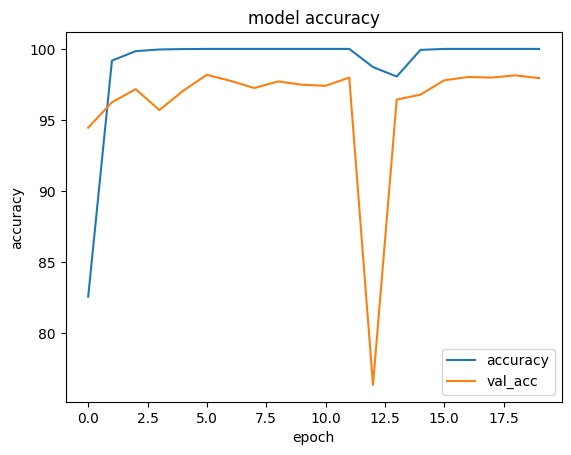

In [33]:
vcpi_util.show_history_plus(history_III, ['accuracy', 'val_acc'])

# Early Stopping and Learning Rate Scheduler

## Early Stopping

The early stop criterion allows us to be more relaxed when setting the number of epochs, with this approach we can set a higher number of epochs without worrying that the we are just wasting training time. If the model learns fast the training process will stop early, if the model takes longer to train, then we won't stop it prematurely due to a low number of epochs.

In [34]:
class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False


## Learning Rate Scheduler

A learning rate scheduler adapts the learning rate during training. 

It usually depends only on the passage of epochs or batchs. Some optimizers start with a large learning rate, and decrease it over time, while others define a warmup period, increasing the learning rate faster in the beginning, and then decreasing it over a longer period of time. 

Another option is to make the adaptation of the learning rate dependent on the progress of some metric, such as the loss. For instance we can reduce the learning rate when the model is no longer making progress after a number of epochs. This is the reduce on plateau approach.

The list of schedulers implemented in torch can be found in the [Documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

c:\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


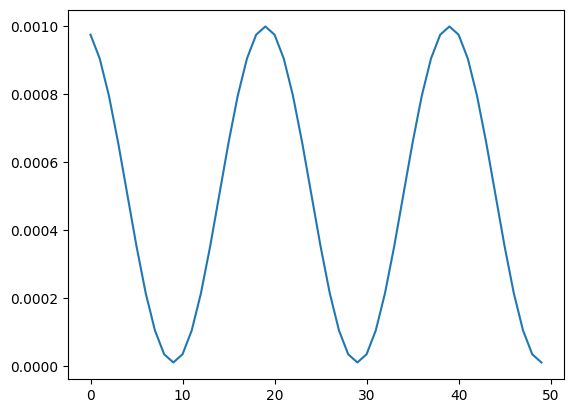

In [35]:
optimizer_aux = torch.optim.Adam(model_Conv_III.parameters(), lr=0.001)

#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer_aux, start_factor=1, end_factor=0.1, total_iters =20)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_aux, 10, 0.00001)

lrs = []
for epoch in range(50):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())

plt.plot(lrs)


In [36]:
def train_III(model, train_loader, val_loader, epochs, loss_fn, optimizer, scheduler, early_stopper, save_prefix = 'model'):

    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        with torch.no_grad():
            v_correct = 0
            val_loss = 0.0
            for i,t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                
                val_loss += loss_fn(o, t)

                v_correct += (p == t).sum()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Val Loss: {val_loss:0.6f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(v_accuracy.cpu().numpy())
        history['val_loss'].append(val_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())
 
        ###### Saving ######
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_{epoch}.pt')

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)


In [37]:
model_Conv_IV = Conv(len(train_set.classes))
model_Conv_IV.to(device)

optimizer_IV = torch.optim.Adam(model_Conv_IV.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_IV, mode='min', factor = 0.1, patience=3)

early_stop = Early_Stopping(9)

history_IV = train_III(model_Conv_IV, train_partial_loader, val_loader, EPOCHS, loss_fn, optimizer_IV, scheduler, early_stop, 'model_gtsrb_best')

Epoch: 000; Loss: 0.015853; Accuracy: 83.3333; Val Loss: 0.006376; Val Acc: 94.3023; Elapsed time: 6.2898
Epoch: 001; Loss: 0.001245; Accuracy: 99.1176; Val Loss: 0.005128; Val Acc: 94.3798; Elapsed time: 6.2594
Epoch: 002; Loss: 0.000468; Accuracy: 99.7549; Val Loss: 0.004288; Val Acc: 95.1550; Elapsed time: 6.4371
Epoch: 003; Loss: 0.000185; Accuracy: 99.9510; Val Loss: 0.003143; Val Acc: 96.7442; Elapsed time: 6.3653
Epoch: 004; Loss: 0.000245; Accuracy: 99.9118; Val Loss: 0.003080; Val Acc: 96.5116; Elapsed time: 6.2916
Epoch: 005; Loss: 0.000032; Accuracy: 100.0000; Val Loss: 0.003686; Val Acc: 96.2403; Elapsed time: 6.3027
Epoch: 006; Loss: 0.000020; Accuracy: 100.0000; Val Loss: 0.002831; Val Acc: 97.1705; Elapsed time: 6.2710
Epoch: 007; Loss: 0.000010; Accuracy: 100.0000; Val Loss: 0.002603; Val Acc: 97.0155; Elapsed time: 6.3464
Epoch: 008; Loss: 0.000007; Accuracy: 100.0000; Val Loss: 0.002652; Val Acc: 97.5194; Elapsed time: 6.3213
Epoch: 009; Loss: 0.000006; Accuracy: 100.

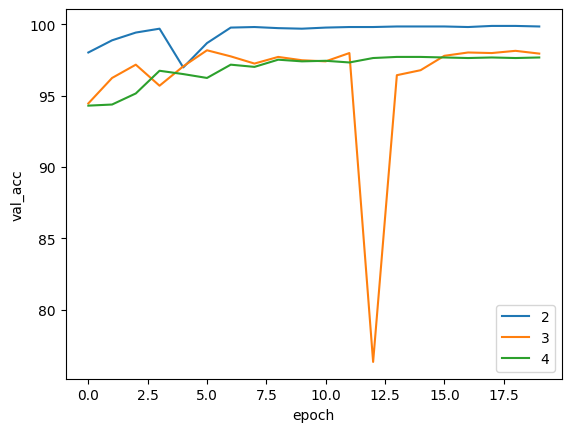

In [38]:
vcpi_util.show_histories([history_II, history_III, history_IV],['2','3','4'], 'val_acc')